# CoLeaf CNN

## Imports

In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from dataset import CoLeafDataset
from sklearn.model_selection import train_test_split
from network import Net
import torch.optim as optim
import torch.nn as nn
from tqdm.notebook import tqdm

In [2]:
import os
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
%time import os
%time import pandas as pd
%time import torch
%time from torchvision import transforms
%time from torch.utils.data import DataLoader, Subset
%time from dataset import CoLeafDataset
%time from sklearn.model_selection import train_test_split
%time from network import Net
%time import torch.optim as optim
%time import torch.nn as nn
%time from tqdm.notebook import tqdm
%time import pickle
%time import seaborn as sns
%time import matplotlib.pyplot as plt

CPU times: user 5 μs, sys: 3 μs, total: 8 μs
Wall time: 12.2 μs
CPU times: user 1.64 s, sys: 469 ms, total: 2.11 s
Wall time: 2.92 s
CPU times: user 1.88 s, sys: 2.38 s, total: 4.26 s
Wall time: 23.3 s
CPU times: user 1.37 s, sys: 1.5 s, total: 2.86 s
Wall time: 16 s
CPU times: user 5 μs, sys: 5 μs, total: 10 μs
Wall time: 12.4 μs
CPU times: user 2.08 ms, sys: 1.78 ms, total: 3.86 ms
Wall time: 27.5 ms
CPU times: user 1.88 s, sys: 495 ms, total: 2.38 s
Wall time: 4.88 s
CPU times: user 0 ns, sys: 840 μs, total: 840 μs
Wall time: 3.76 ms
CPU times: user 5 μs, sys: 3 μs, total: 8 μs
Wall time: 10.7 μs
CPU times: user 3 μs, sys: 3 μs, total: 6 μs
Wall time: 8.82 μs
CPU times: user 3 μs, sys: 2 μs, total: 5 μs
Wall time: 7.15 μs
CPU times: user 3 μs, sys: 2 μs, total: 5 μs
Wall time: 6.2 μs
CPU times: user 316 ms, sys: 156 ms, total: 471 ms
Wall time: 1.55 s
CPU times: user 2 μs, sys: 2 μs, total: 4 μs
Wall time: 7.39 μs


## Parameters

In [17]:
IMG_SIZE        = 224
BATCH_SIZE      = 32
WORKERS         = 4
TRAIN_SPLIT     = 0.8
EPOCHS          = 50
LR              = 0.001
MODEL_VERSION   = "v1"
DATASET_PATH    = "./CoLeaf DATASET"
OUTPUT_PATH     = "./output"
MODEL_PATH     = f"./output/model_{MODEL_VERSION}.pth"

In [11]:
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
os.makedirs(OUTPUT_PATH, exist_ok=True)

tfs = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),          
    transforms.ToTensor(),           
    transforms.Normalize(            
        mean=[0.5, 0.5, 0.5], 
        std=[0.5, 0.5, 0.5]
    )
])

dataset = CoLeafDataset(
    data_dir=DATASET_PATH,
    transform=tfs
)

classes = dataset.classes

range_train, range_test = train_test_split(range(len(dataset)), train_size=TRAIN_SPLIT, stratify=dataset.labels)

train_dataset = Subset(dataset, range_train)
test_dataset  = Subset(dataset, range_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS)

  0%|          | 0/10 [00:00<?, ?it/s]

## Training

In [ ]:
net = Net().to(device)
print(f"Model is on: {next(net.parameters()).device}")

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LR)
train_losses = [] 
val_losses = []

for epoch in tqdm(range(EPOCHS), desc="Epochs"): 

    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader), desc="Batches", leave=False):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    
    net.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = loss_function(outputs, labels)
            val_running_loss += loss.item()
            
    val_epoch_loss = val_running_loss / len(test_loader)
    val_losses.append(val_epoch_loss)
    net.train()

torch.save(net.state_dict(), MODEL_PATH)

with open(os.path.join(OUTPUT_PATH, f'train_losses_{MODEL_VERSION}.pkl'), 'wb') as f:
    pickle.dump(train_losses, f)
    
with open(os.path.join(OUTPUT_PATH, f'val_losses_{MODEL_VERSION}.pkl'), 'wb') as f:
    pickle.dump(val_losses, f)

Model is on: cuda:0


  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
with open(os.path.join(OUTPUT_PATH, f'train_losses_{MODEL_VERSION}.pkl'), 'rb') as f:
        train_losses = pickle.load(f)
        
with open(os.path.join(OUTPUT_PATH, f'val_losses_{MODEL_VERSION}.pkl'), 'rb') as f:
        val_losses = pickle.load(f)

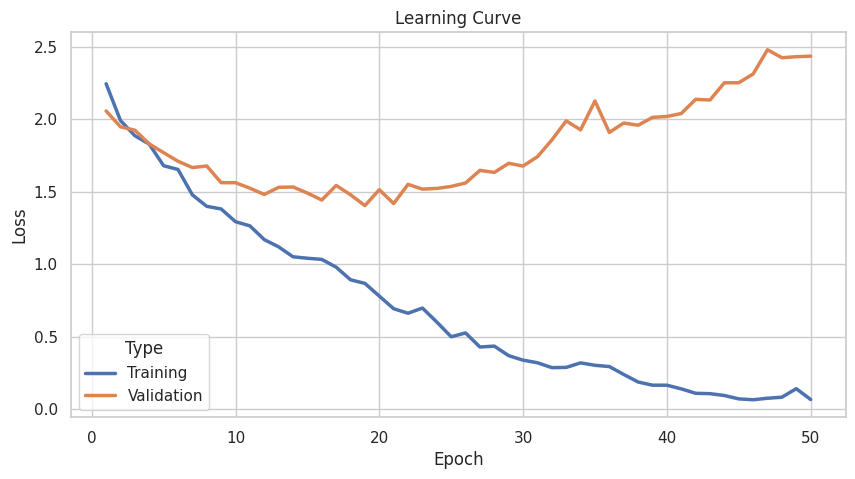

In [ ]:
epochs_range = range(1, EPOCHS + 1)
graphdata = []
graphdata += [{'Epoch': epoch, 'Loss': loss, 'Type': 'Train'} for epoch, loss in zip(epochs_range, train_losses)]
graphdata += [{'Epoch': epoch, 'Loss': loss, 'Type': 'Test'} for epoch, loss in zip(epochs_range, val_losses)]

df_losses = pd.DataFrame(graphdata)

# Plot Learning Curve
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.lineplot(df_losses, x='Epoch', y='Loss', hue='Type', linewidth=2.5)
plt.title('Learning Curve')
plt.legend(title='')
plt.savefig(os.path.join(OUTPUT_PATH, "learning_curve.png"))
plt.show()

## Testing

In [18]:
net = Net().to(device)
net.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [21]:
correct = 0
total = 0

net.eval()

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in dataset.classes}
total_pred = {classname: 0 for classname in dataset.classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[dataset.classes[label]] += 1
            total_pred[dataset.classes[label]] += 1
            
        

print(f'Accuracy of the network on the test images: {100 * correct // total} %')
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy of the network on the test images: 88 %
Accuracy for class: boron-B is 70.0 %
Accuracy for class: calcium-Ca is 100.0 %
Accuracy for class: healthy is 100.0 %
Accuracy for class: iron-Fe is 61.5 %
Accuracy for class: magnesium-Mg is 75.0 %
Accuracy for class: manganese-Mn is 94.1 %
Accuracy for class: more-deficiencies is 100.0 %
Accuracy for class: nitrogen-N is 84.6 %
Accuracy for class: phosphorus-P is 93.9 %
Accuracy for class: potasium-K is 89.5 %


## Overview of the dataset
The dataset consists of images of coffee leaves with varios nutrient deficiencies.

In [ ]:
images = []
for i in range(max(dataset.labels)+1):
    images.append(dataset.labels.count(i))

df = pd.DataFrame({"Class": dataset.classes, "Number of images": images})
display(df)

,Class,Number of images
0,boron-B,101
1,calcium-Ca,162
2,healthy,6
3,iron-Fe,65
4,magnesium-Mg,79
5,manganese-Mn,83
6,more-deficiencies,104
7,nitrogen-N,64
8,phosphorus-P,246
9,potasium-K,96


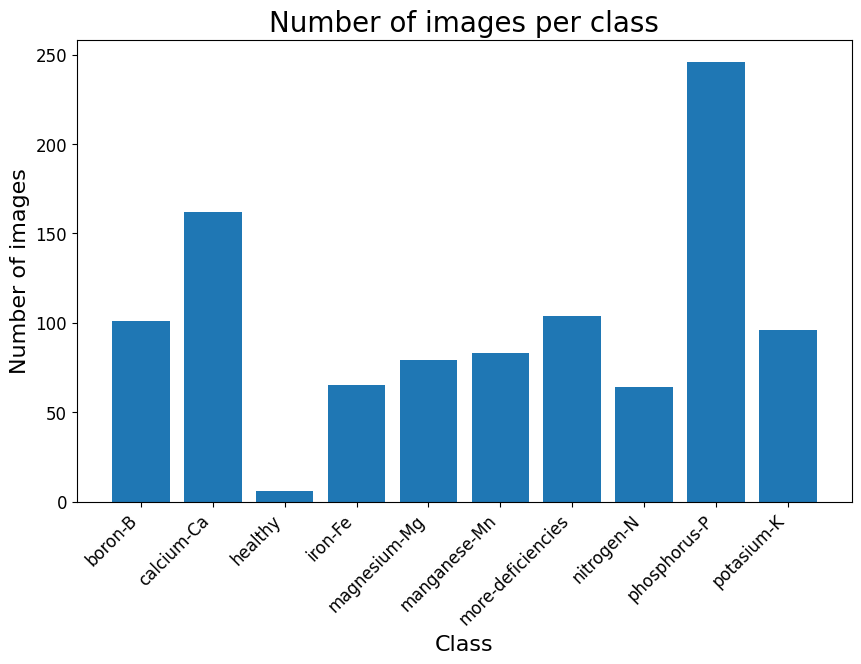

In [ ]:
# Plot number of images per class
plt.figure(figsize=(10, 6))
bars = plt.bar(dataset.classes, images)
plt.title("Number of images per class", fontsize=20)
plt.xlabel("Class", fontsize=16)
plt.ylabel("Number of images", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(os.path.join(OUTPUT_PATH, "images_per_class.png"))
plt.show()